In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install pyspark==3.5.4

In [ ]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('FinalProject').config("spark.executor.memory","16g").getOrCreate()
spark

In [ ]:
PATH = '/content/drive/MyDrive/DataSet/'

In [ ]:
# Read dataset.csv
dataset = spark.read.csv(PATH+'TrainTest01.csv', header=True, inferSchema=True)
dataset.printSchema()
dataset.show(20,False)
dataset.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- DEP_DELAY_NEW: double (nullable = true)
 |-- DEP_DEL15: double (nullable = true)
 |-- ARR_DEL15: double (nullable = true)

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+--------+---------+-------------+---------+---------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|DEP_DELAY_NEW|DEP_DEL15|ARR_DEL15|
+------------------------+-------+-

405262

In [ ]:
train, test = dataset.randomSplit(weights=[0.8,0.2], seed=2022)

<ipython-input-40-326e108d9148>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


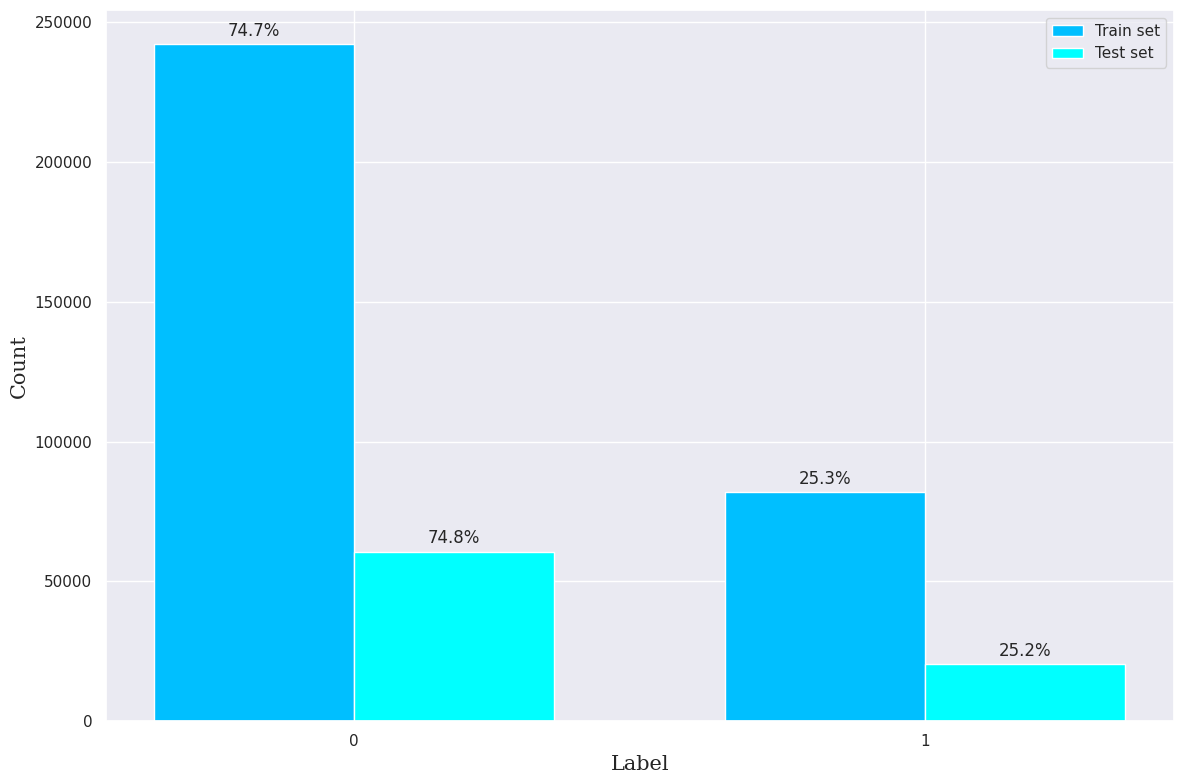

In [ ]:
df_train = train.select('ARR_DEL15').toPandas()
df_test = test.select('ARR_DEL15').toPandas()

label_train = list(df_train.ARR_DEL15.value_counts())
label_test = list(df_test.ARR_DEL15.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')
plt.xticks([r for r in range(len(label_train))], ['0', '1'])
fig.tight_layout()
plt.show()

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15'],
                            outputCol='features')

In [ ]:
DT = DecisionTreeClassifier(maxDepth=16, featuresCol='features', labelCol='ARR_DEL15')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer, oneHotEncoder, assembler, DT])

In [ ]:
model_DT = pipeline.fit(train)

In [ ]:
Trained = model_DT.transform(test)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+--------+---------+-------------+---------+---------+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|DEP_DELAY_NEW|DEP_DEL15|ARR_DEL15|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|       ORIGINVec|         DESTVec|            features| rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+--------+---------+-------------+---------+---------+----------------------+-----------+---------+--------------------+----------------+----------------+--------------------+--------------+--------------------+-------

81141